In [54]:
# !pip install pandas
# !pip install seaborn
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

## 0. 라이브러리 불러오기

In [55]:
import os
import cv2
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from spectral import open_image
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

warnings.filterwarnings(action='ignore')


## 1. 데이터셋 불러오기

In [56]:
def load_hyperspectral_data(hyperspectral_folder, label_folder, num_files=10):
    """ Load hyperspectral data from HDR and RAW files, flatten, and concatenate. """
    X, y = [], []
    file_list = sorted([f for f in os.listdir(label_folder) if f.endswith('.png')])[:num_files]
    
    for label_file in file_list:
        base_name = os.path.splitext(label_file)[0]
        hdr_path = os.path.join(hyperspectral_folder, base_name + '.hdr')
        raw_path = hdr_path.replace('.hdr', '.raw')
        label_path = os.path.join(label_folder, label_file)
        
        if not os.path.exists(hdr_path):
            continue
        
        # Load hyperspectral cube
        img = open_image(hdr_path)
        hyperspectral_cube = img.load()
        flattened_cube = hyperspectral_cube.reshape(-1, hyperspectral_cube.shape[-1])  # Shape: (96000, 256)
        
        # Load corresponding label image
        label_img = Image.open(label_path).convert('L')
        label_array = np.array(label_img).flatten()
        label_array = np.where(label_array < 10, 0, np.where(label_array > 240, 2, 1))
        
        X.append(flattened_cube)
        y.append(label_array)
    
    # Concatenate all images together
    X = np.vstack(X)  # Shape: (num_files * 96000, 256)
    y = np.hstack(y)  # Shape: (num_files * 96000, 1)
    return X, y

# Set the dataset folder paths
hyperspectral_folder = r"Z:/5. 연구소/2. 국책과제/2023-기술혁신-시장대응형(스마트APC)/참고자료/2024 자체 구축 데이터셋/사과/241205 사과 외부결함/splited"
label_folder = r"Z:/5. 연구소/2. 국책과제/2023-기술혁신-시장대응형(스마트APC)/참고자료/2024 자체 구축 데이터셋/사과/241205 사과 외부결함/splited_label"
X, y = load_hyperspectral_data(hyperspectral_folder, label_folder, num_files=10)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## 2. 전처리 함수 정의

In [57]:
def apply_snv(data):
    """ Apply Standard Normal Variate (SNV) Preprocessing """
    return (data - np.mean(data, axis=1, keepdims=True)) / np.std(data, axis=1, keepdims=True)

def apply_savgol_filter(data, window_size=5, polyorder=2):
    """ Apply Savitzky-Golay filter for smoothing """
    from scipy.signal import savgol_filter
    return savgol_filter(data, window_length=window_size, polyorder=polyorder, axis=1)

def apply_differencing(data):
    """ Apply Spectral Differencing """
    return np.diff(data, axis=1)


## 4. 실험 - 전처리와 차분을 경우별로 적용

In [58]:
experiments = []
settings = [(False, False, False), 
            (False, False, True), 
            (False, True, False), 
            (False, True, True),
            (True, False, False), 
            (True, False, True), 
            (True, True, False), 
            (True, True, True),
            ]

for snv, savgol, diff in settings:
    X_train_proc, X_test_proc = X_train.copy(), X_test.copy()
    if savgol:
        X_train_proc = apply_savgol_filter(X_train_proc)
        X_test_proc = apply_savgol_filter(X_test_proc)
    if snv:
        X_train_proc = apply_snv(X_train_proc)
        X_test_proc = apply_snv(X_test_proc)
    if diff:
        X_train_proc = apply_differencing(X_train_proc)
        X_test_proc = apply_differencing(X_test_proc)

    model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    model.fit(X_train_proc, y_train)
    joblib.dump(model,f'./weights/{int(snv)}_{int(savgol)}_{int(diff)}_apple_preprocessing_test_model.pkl')
    y_pred = model.predict(X_test_proc)
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, model.predict_proba(X_test_proc), multi_class='ovr') if hasattr(model, 'predict_proba') else None
    accuracy = accuracy_score(y_test, y_pred)
    experiments.append([snv, savgol, diff, accuracy, f1, auc])

# Convert results to DataFrame
exp_results_df = pd.DataFrame(experiments, columns=['SNV', 'Savgol', 'Differencing', 'Accuracy', 'F1-score', 'roc-auc-score'])
print(exp_results_df.to_string(index=False))

# True False is best parameter (0.984563)

  SNV  Savgol  Differencing  Accuracy  F1-score  roc-auc-score
False   False         False  0.982395  0.982266       0.986803
False   False          True  0.971505  0.970326       0.976683
False    True         False  0.981579  0.981443       0.986961
False    True          True  0.981812  0.981618       0.990409
 True   False         False  0.983514  0.983448       0.990411
 True   False          True  0.960919  0.955467       0.911210
 True    True         False  0.983747  0.983692       0.989083
 True    True          True  0.977172  0.976394       0.972492


In [59]:
def normalize_band(band):
    """Normalize a band to the range 0-255."""
    band_min, band_max = np.min(band), np.max(band)
    return ((band - band_min) / (band_max - band_min) * 255).astype(np.uint8)

def generate_rgb_image(hyperspectral_data):
    """Generate an RGB image using specific bands."""
    r_band = normalize_band(hyperspectral_data[:, :, 100])
    g_band = normalize_band(hyperspectral_data[:, :, 150])
    b_band = normalize_band(hyperspectral_data[:, :, 200])
    return np.squeeze(np.stack([r_band, g_band, b_band], axis=-1))

Hsi20241205152845_0139_1


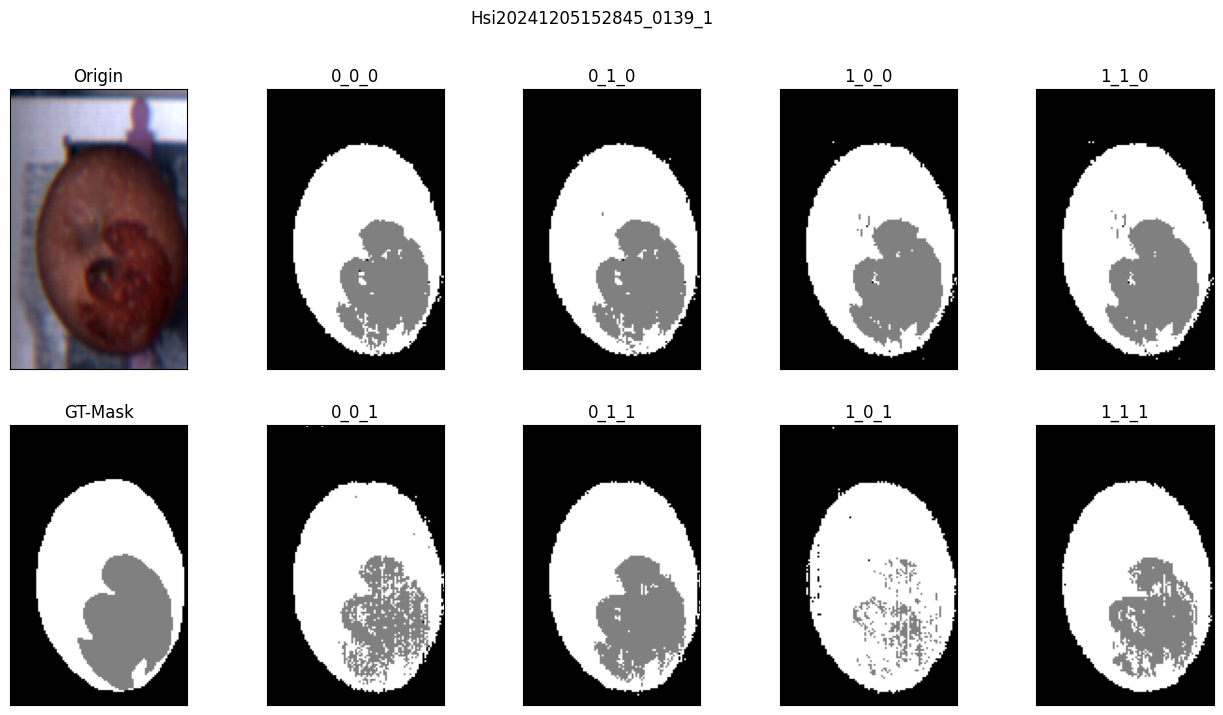

Hsi20241205152845_0139_2


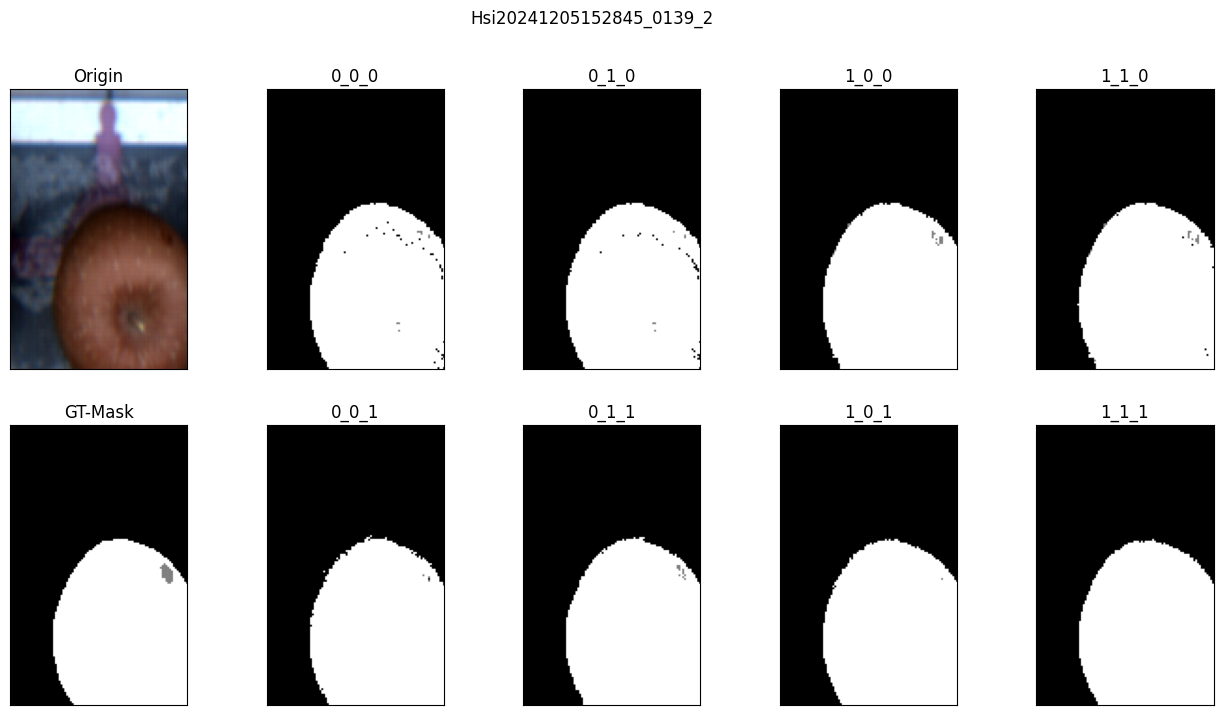

Hsi20241205152845_0139_3


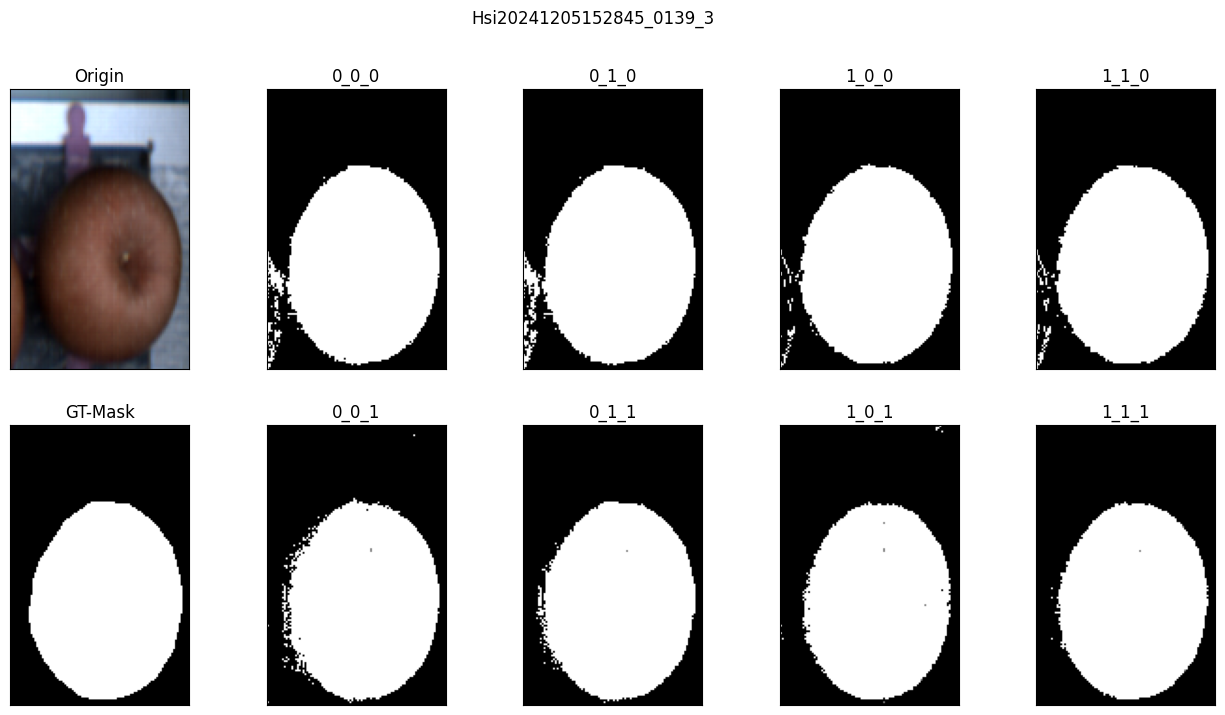

Hsi20241205152845_0139_4


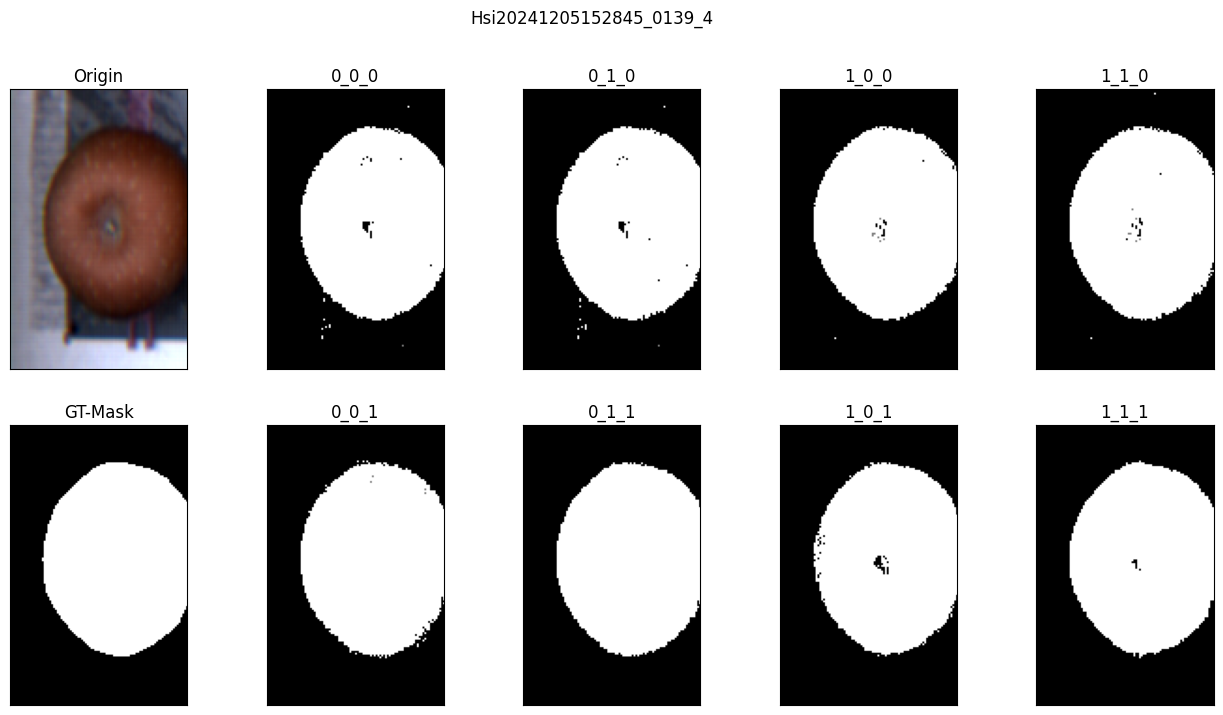

Hsi20241205152845_0139_5


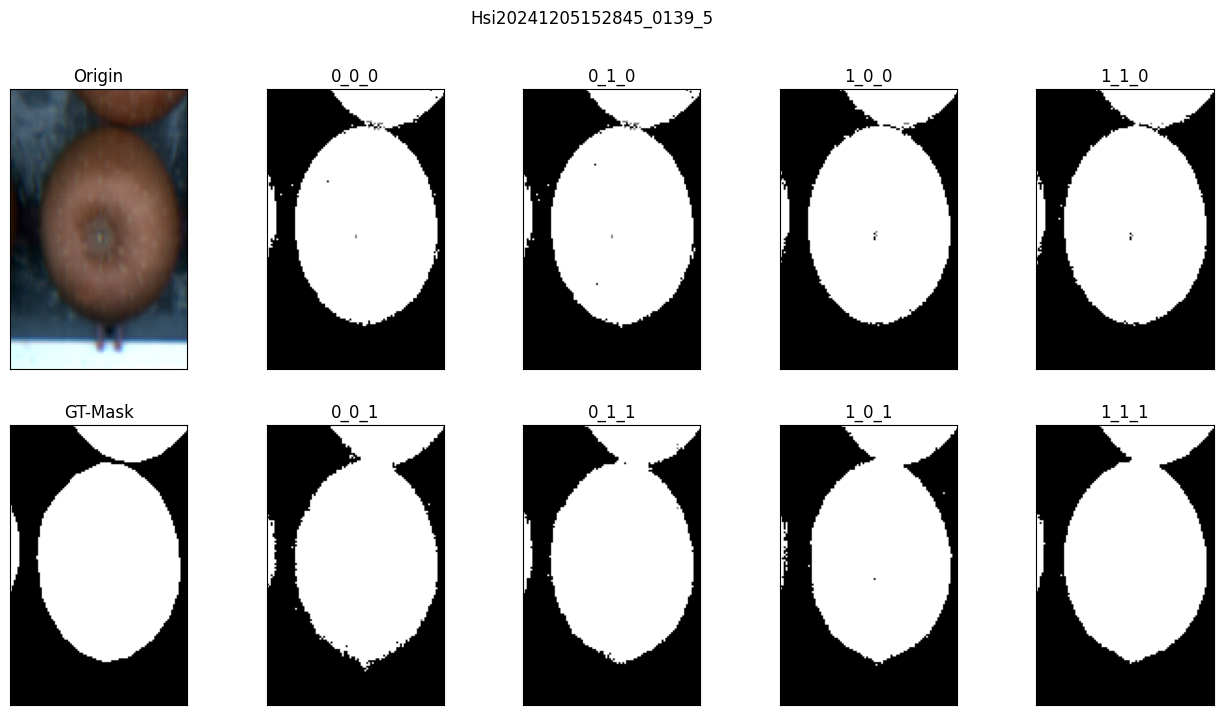

Hsi20241205152845_0139_6


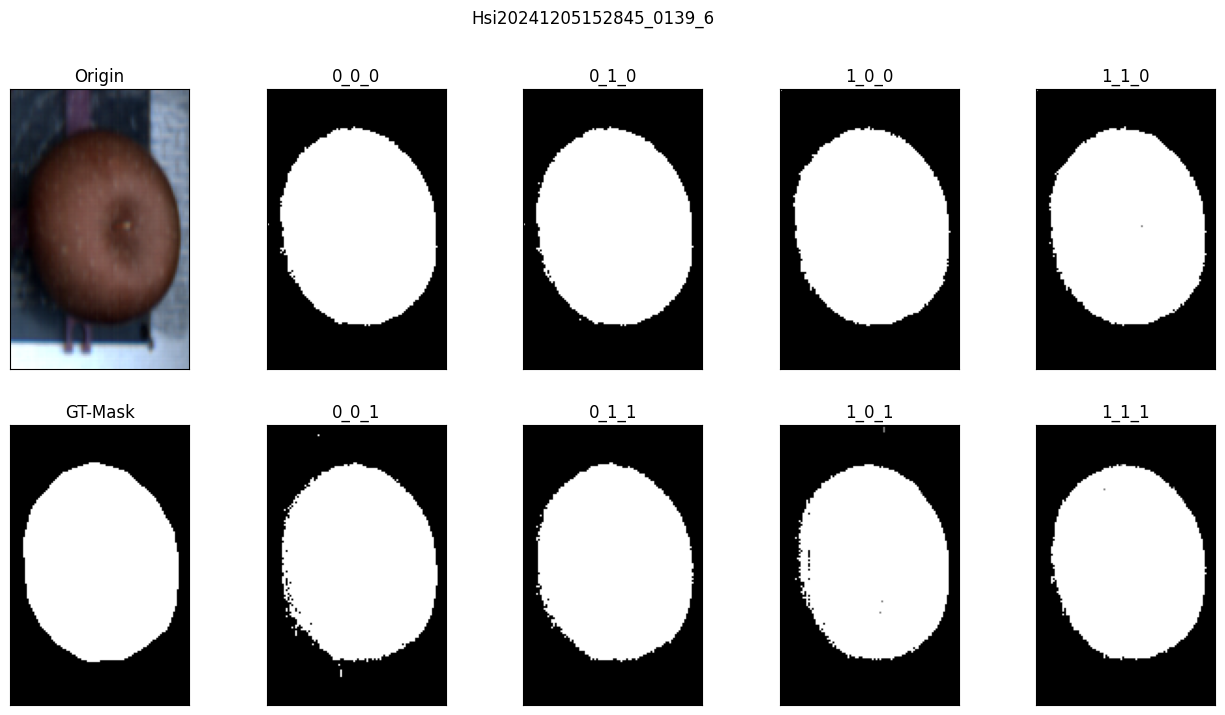

Hsi20241205153418_0140_1


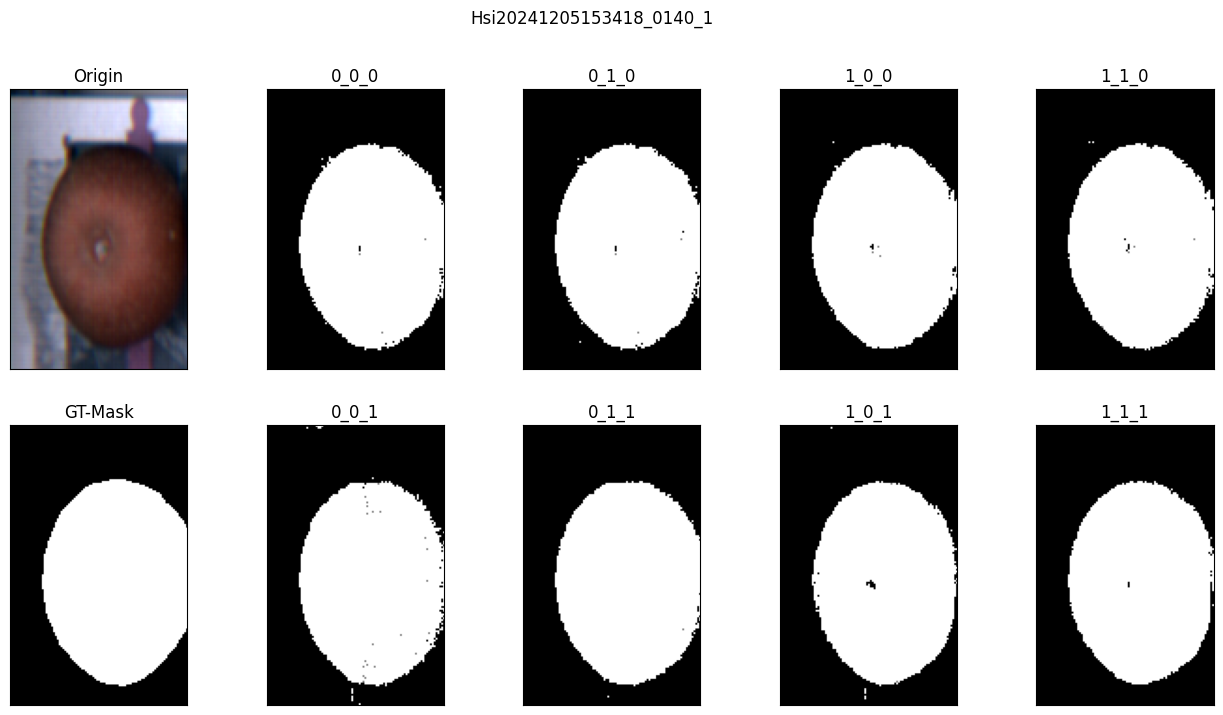

Hsi20241205153418_0140_2


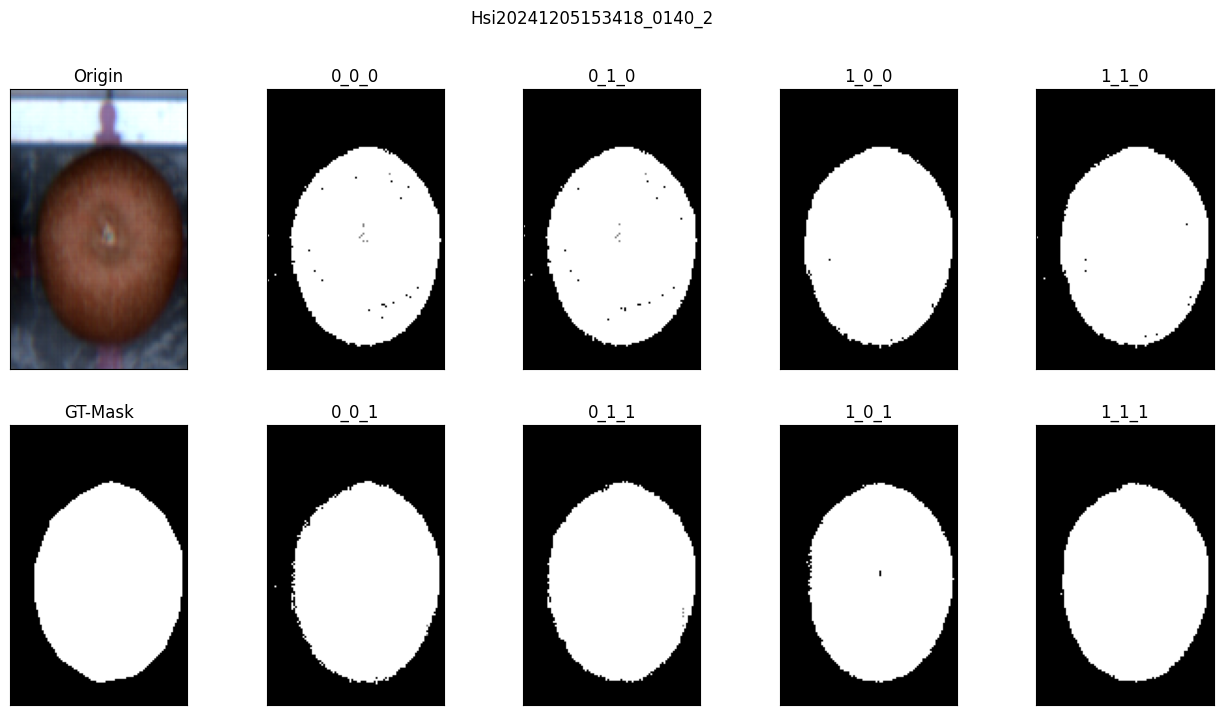

Hsi20241205153418_0140_3


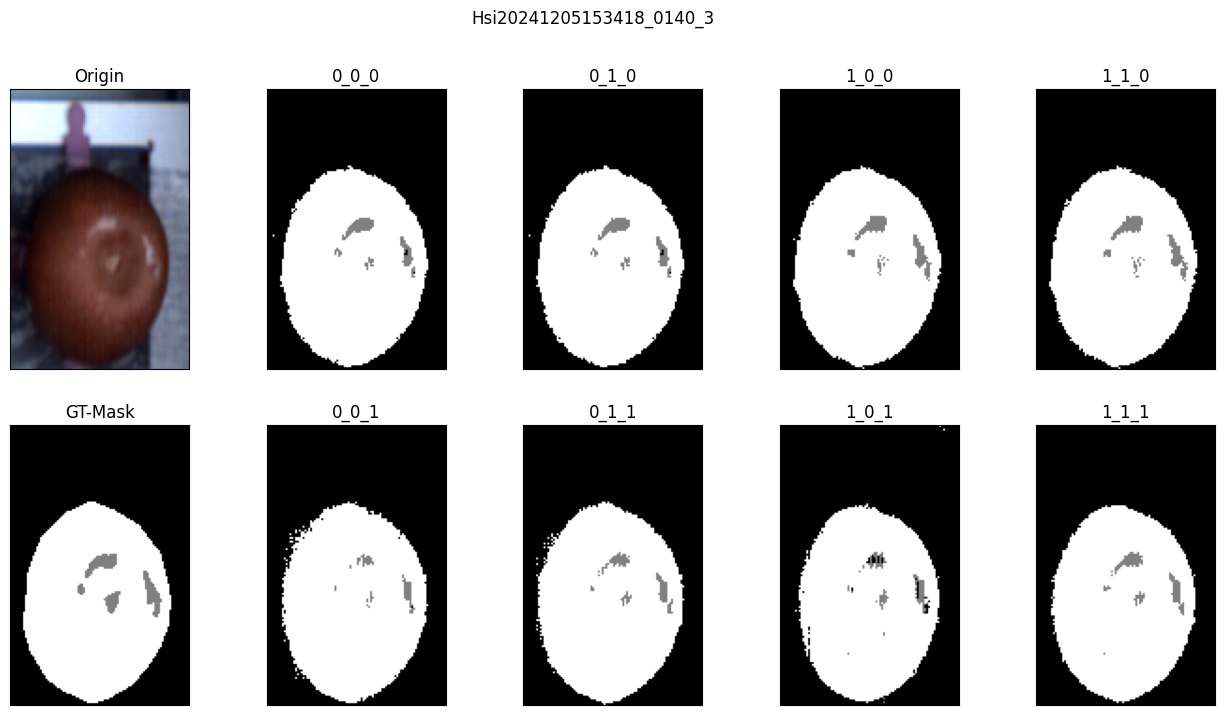

Hsi20241205153418_0140_4


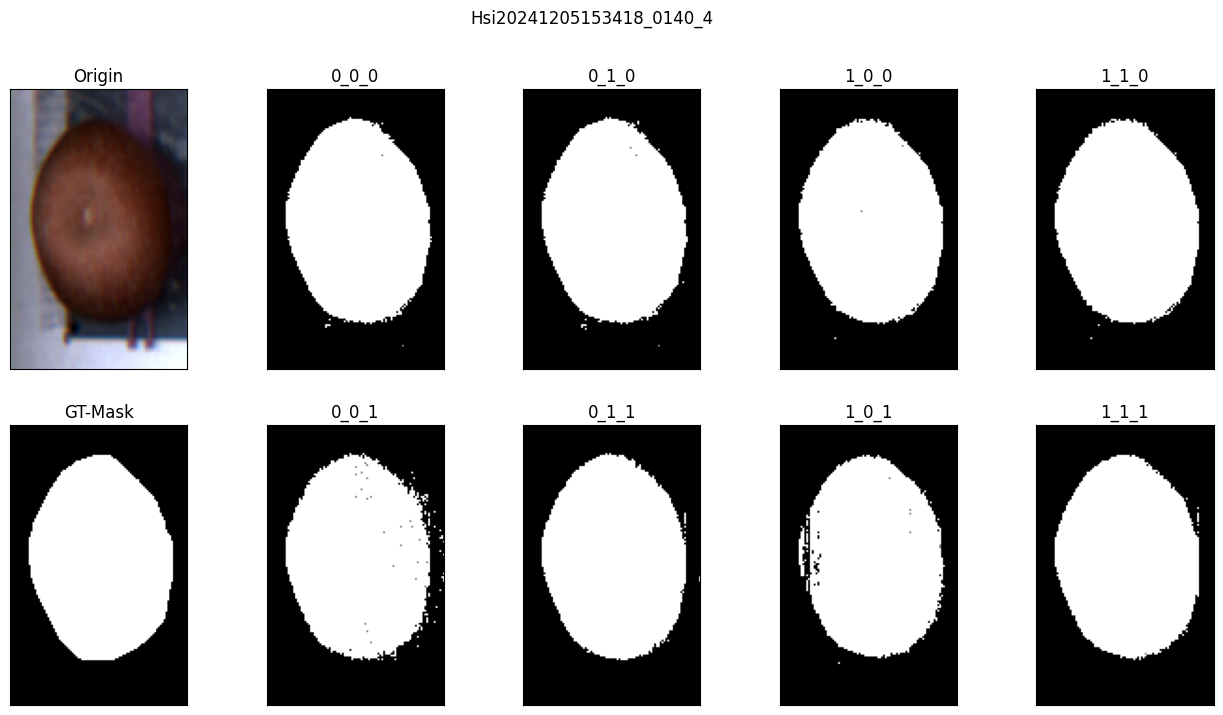

In [60]:
file_list = sorted([f for f in os.listdir(label_folder) if f.endswith('.png')])[:10]

for label_file in file_list:
    base_name = os.path.splitext(label_file)[0]
    hdr_path = os.path.join(hyperspectral_folder, base_name + '.hdr')
    raw_path = hdr_path.replace('.hdr', '.raw')
    label_path = os.path.join(label_folder, label_file)
    
    if not os.path.exists(hdr_path):
        continue
    
    # Load hyperspectral cube
    img = open_image(hdr_path)
    hyperspectral_cube = img.load()
    flattened_cube = hyperspectral_cube.reshape(-1, hyperspectral_cube.shape[-1])  # Shape: (96000, 256)
    
    # Load corresponding label image
    label_img = Image.open(label_path).convert('L')

    print(base_name)

    plt.figure(figsize=(16, 8))
    plt.suptitle(base_name)

    plt.subplot(2, 5, 1)
    plt.title("Origin")
    rgb_image = generate_rgb_image(hyperspectral_cube)
    plt.imshow(rgb_image)

    plt.subplot(2, 5, 6)
    plt.title("GT-Mask")
    label_image = label_img.copy()
    plt.imshow(label_image, cmap='gray')

    plt.subplot(2, 5, 2)
    plt.title("0_0_0")
    model = joblib.load('./weights/0_0_0_apple_preprocessing_test_model.pkl')
    pred_image = model.predict(flattened_cube).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    plt.subplot(2, 5, 3)
    plt.title("0_1_0")
    model = joblib.load('./weights/0_1_0_apple_preprocessing_test_model.pkl')
    pred_image = model.predict(apply_savgol_filter(flattened_cube)).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    plt.subplot(2, 5, 4)
    plt.title("1_0_0")
    model = joblib.load('./weights/1_0_0_apple_preprocessing_test_model.pkl')
    pred_image = model.predict(apply_snv(flattened_cube)).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    plt.subplot(2, 5, 5)
    plt.title("1_1_0")
    model = joblib.load('./weights/1_1_0_apple_preprocessing_test_model.pkl')
    pred_image = model.predict(apply_snv(apply_savgol_filter(flattened_cube))).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    plt.subplot(2, 5, 7)
    plt.title("0_0_1")
    model = joblib.load('./weights/0_0_1_apple_preprocessing_test_model.pkl')
    pred_image = model.predict(apply_differencing(flattened_cube)).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    plt.subplot(2, 5, 8)
    plt.title("0_1_1")
    model = joblib.load('./weights/0_1_1_apple_preprocessing_test_model.pkl')
    pred_image = model.predict(apply_differencing(apply_savgol_filter(flattened_cube))).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    plt.subplot(2, 5, 9)
    plt.title("1_0_1")
    model = joblib.load('./weights/1_0_1_apple_preprocessing_test_model.pkl')
    pred_image = model.predict(apply_differencing(apply_snv(flattened_cube))).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    plt.subplot(2, 5, 10)
    plt.title("1_1_1")
    model = joblib.load('./weights/1_1_1_apple_preprocessing_test_model.pkl')
    pred_image = model.predict(apply_differencing(apply_snv(apply_savgol_filter(flattened_cube)))).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    # 모든 subplot의 눈금을 제거
    for ax in plt.gcf().get_axes():
        ax.set_xticks([])
        ax.set_yticks([])

    plt.savefig(f'./OUTPUT/apple/preprocessing_test/{base_name}.png')
    plt.show()

## 5. 실험 - 머신러닝 모델 종류별 적용

In [61]:
# best_setting = exp_results_df.sort_values(by='F1-score', ascending=False).iloc[0]
best_setting = exp_results_df.sort_values(by='roc-auc-score', ascending=False).iloc[0]
# print("Best Setting:\n", best_setting)

print("Ascening by Accuracy:\n")
print(exp_results_df.sort_values(by='Accuracy', ascending=False).to_string(index=False))
print("\nAscening by F1 score:\n")
print(exp_results_df.sort_values(by='F1-score', ascending=False).to_string(index=False))
print("\nAscening by ROC-AUC score:\n")
print(exp_results_df.sort_values(by='roc-auc-score', ascending=False).to_string(index=False))

Ascening by Accuracy:

  SNV  Savgol  Differencing  Accuracy  F1-score  roc-auc-score
 True    True         False  0.983747  0.983692       0.989083
 True   False         False  0.983514  0.983448       0.990411
False   False         False  0.982395  0.982266       0.986803
False    True          True  0.981812  0.981618       0.990409
False    True         False  0.981579  0.981443       0.986961
 True    True          True  0.977172  0.976394       0.972492
False   False          True  0.971505  0.970326       0.976683
 True   False          True  0.960919  0.955467       0.911210

Ascening by F1 score:

  SNV  Savgol  Differencing  Accuracy  F1-score  roc-auc-score
 True    True         False  0.983747  0.983692       0.989083
 True   False         False  0.983514  0.983448       0.990411
False   False         False  0.982395  0.982266       0.986803
False    True          True  0.981812  0.981618       0.990409
False    True         False  0.981579  0.981443       0.986961
 True   

In [62]:
X_train_proc, X_test_proc = X_train.copy(), X_test.copy()

# if best_setting['SNV']:
#     X_train_proc = apply_snv(X_train_proc)
#     X_test_proc = apply_snv(X_test_proc)
# if best_setting['Savgol']:
#     X_train_proc = apply_savgol_filter(X_train_proc)
#     X_test_proc = apply_savgol_filter(X_test_proc)
# if best_setting['Differencing']:
#     X_train_proc = apply_differencing(X_train_proc)
#     X_test_proc = apply_differencing(X_test_proc)

X_train_proc = apply_differencing(apply_savgol_filter(X_train_proc))
X_test_proc = apply_differencing(apply_savgol_filter(X_test_proc))


models = {
    # 'PLSR': PLSRegression(n_components=255),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    # 'SVM': SVC(kernel='linear', probability=True),
    # 'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    # 'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42),
    'Hist Gradient Boosting': HistGradientBoostingClassifier(),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'k-NN': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1),
    'LightGBM': LGBMClassifier(verbose=0, n_jobs=-1),
    'CatBoost': CatBoostClassifier(verbose=0, thread_count=-1)
}

results = []
for name, model in models.items():
    model.fit(X_train_proc, y_train)
    print(f"{name} model train finished")
    joblib.dump(model, f'./weights/{name}_apple_model_compare.pkl')
    y_pred = model.predict(X_test_proc)
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, model.predict_proba(X_test_proc), multi_class='ovr') if hasattr(model, 'predict_proba') else None
    accuracy = accuracy_score(y_test, y_pred)
    results.append([name, f1, auc, accuracy])

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=['Model', 'F1-score', 'ROC-AUC', 'Accuracy'])
print(results_df.to_string(index=False))


Random Forest model train finished
Hist Gradient Boosting model train finished
Extra Trees model train finished
k-NN model train finished
Decision Tree model train finished
XGBoost model train finished
LightGBM model train finished
CatBoost model train finished
                 Model  F1-score  ROC-AUC  Accuracy
         Random Forest  0.972202 0.993820  0.973254
Hist Gradient Boosting  0.980425 0.997762  0.980646
           Extra Trees  0.969156 0.995705  0.970969
                  k-NN  0.981618 0.990409  0.981812
         Decision Tree  0.952531 0.915328  0.952174
               XGBoost  0.980693 0.998180  0.980902
              LightGBM  0.979274 0.997825  0.979503
              CatBoost  0.979972 0.997390  0.980156


Hsi20241205152845_0139_1


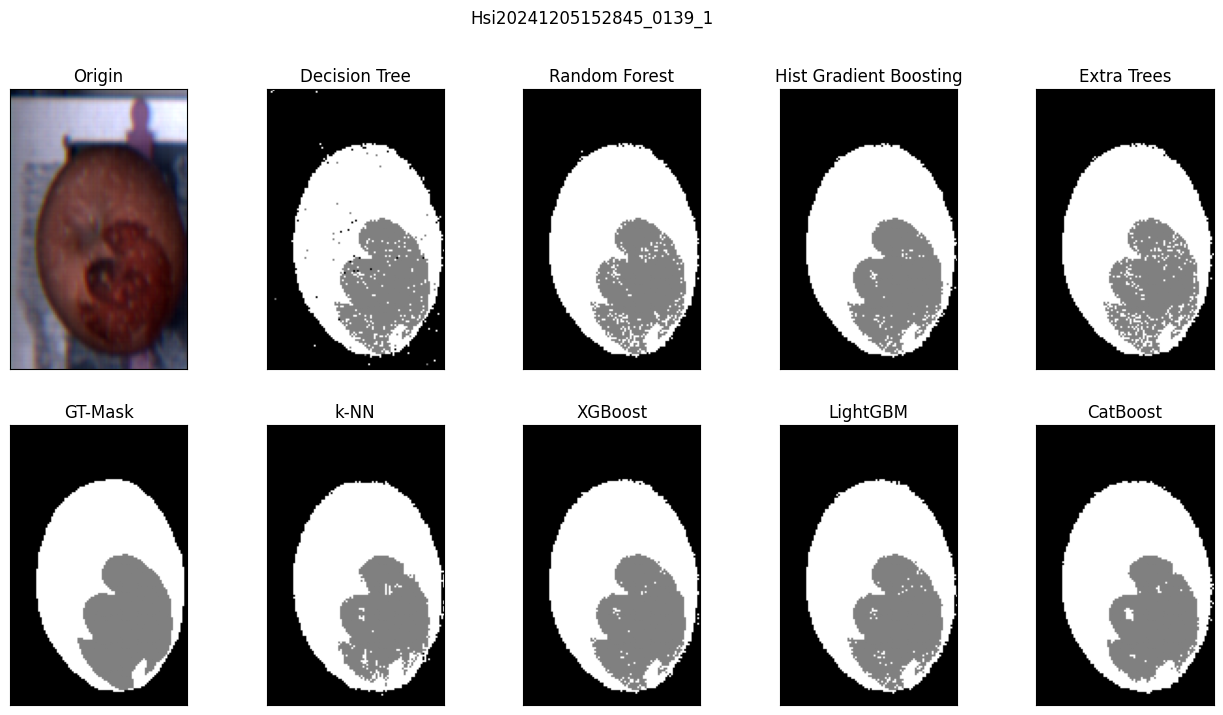

Hsi20241205152845_0139_2


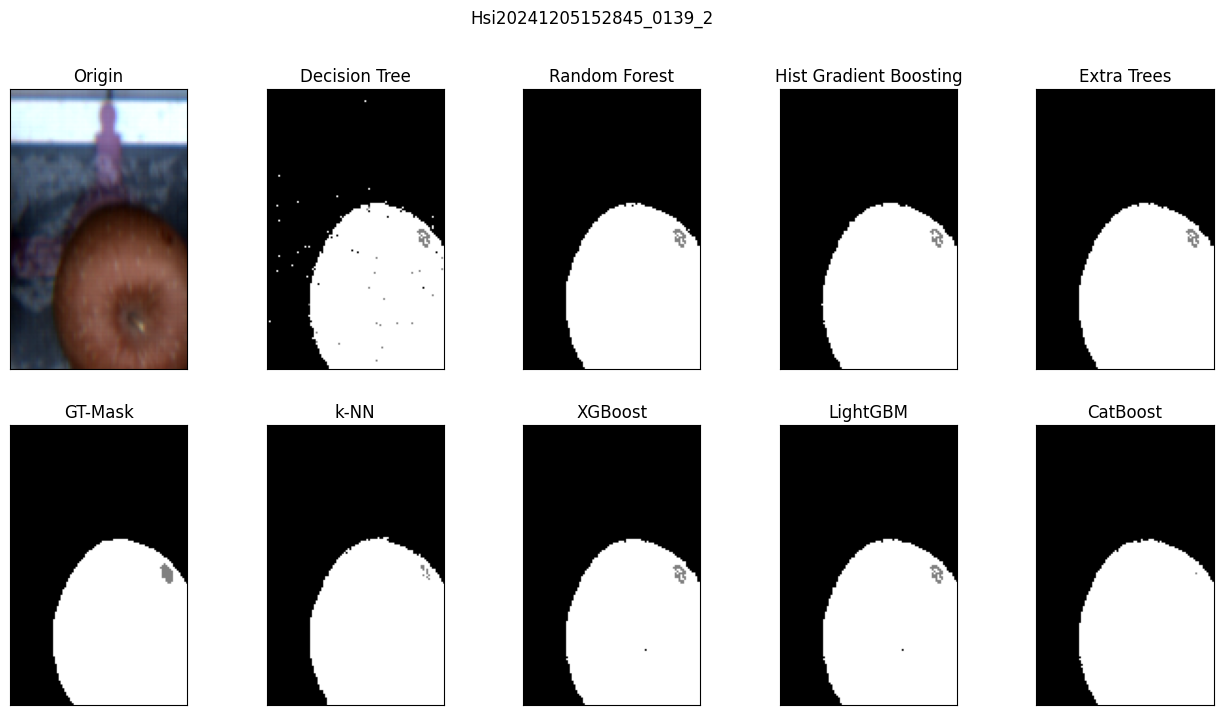

Hsi20241205152845_0139_3


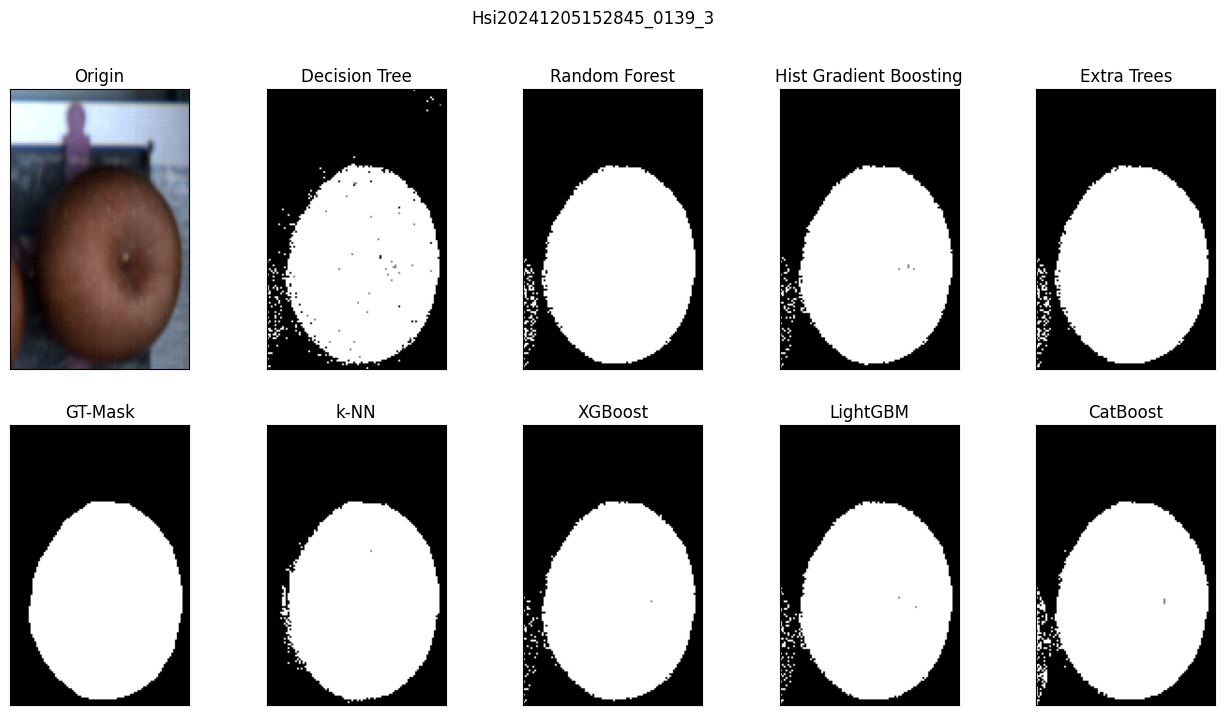

Hsi20241205152845_0139_4


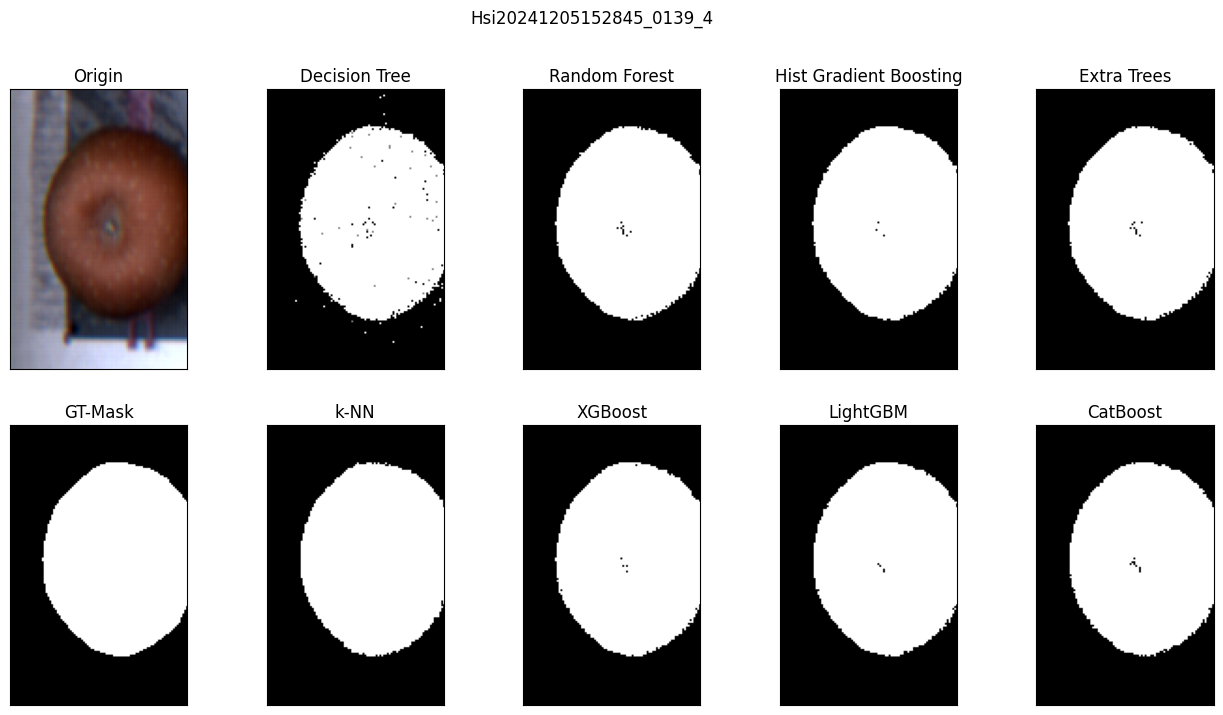

Hsi20241205152845_0139_5


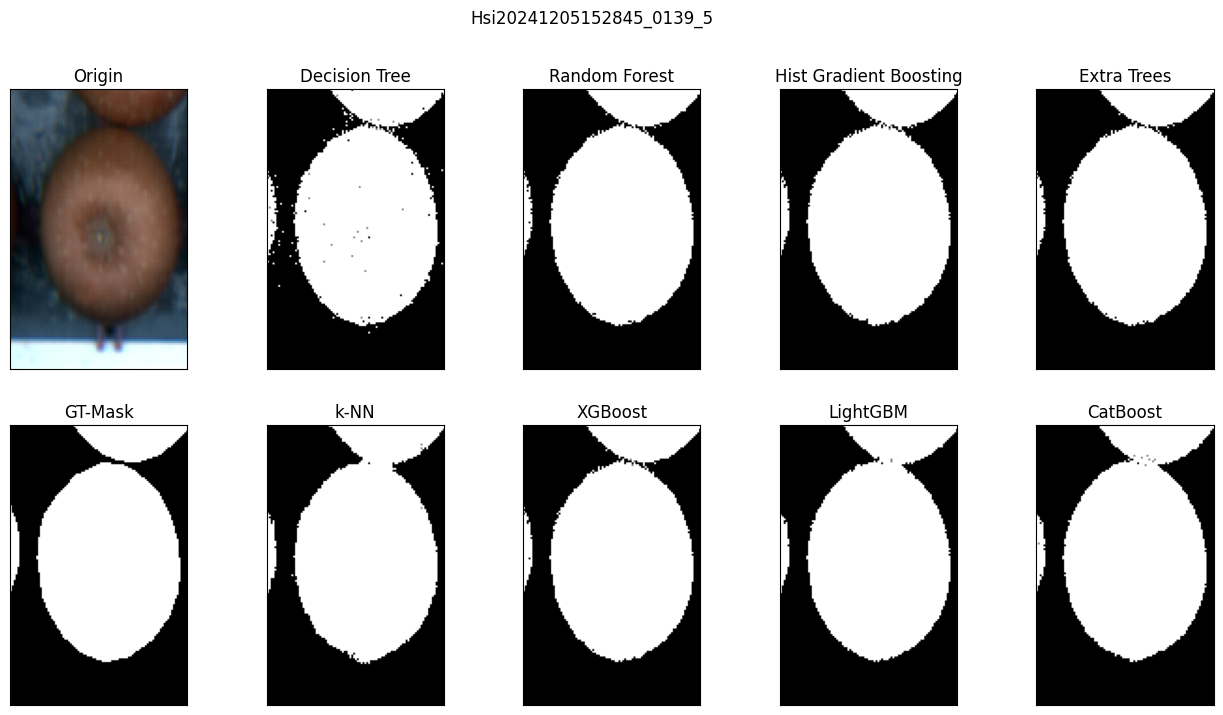

Hsi20241205152845_0139_6


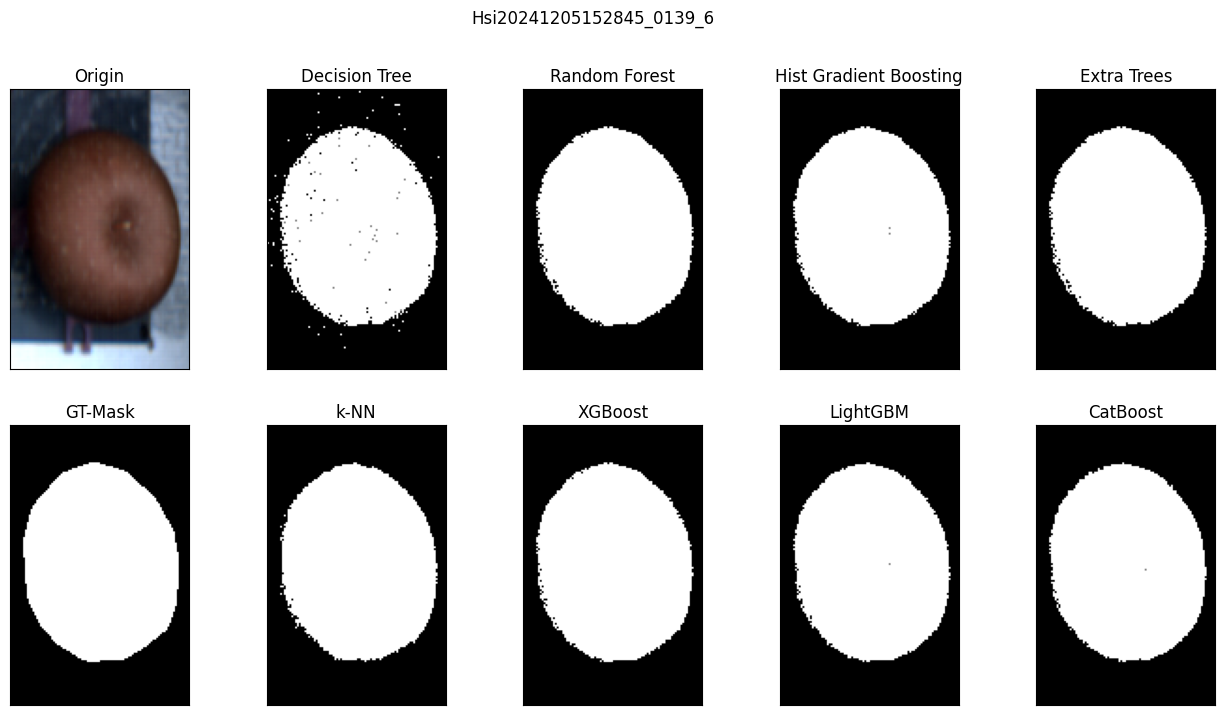

Hsi20241205153418_0140_1


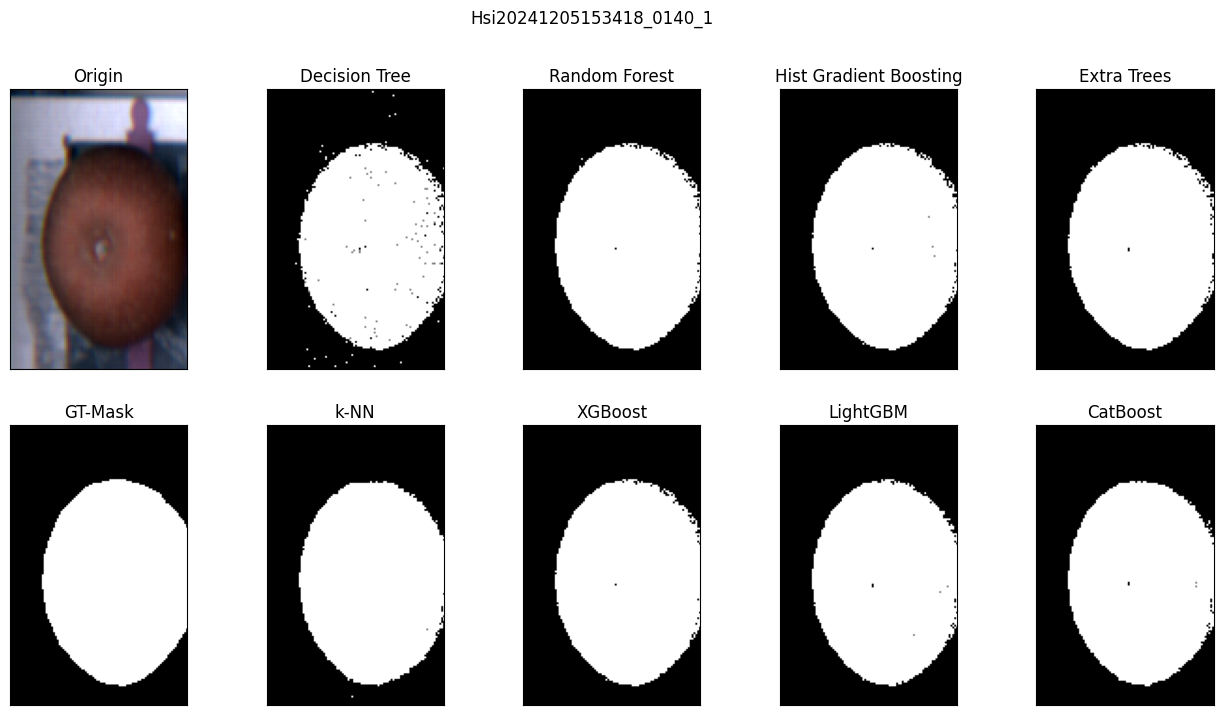

Hsi20241205153418_0140_2


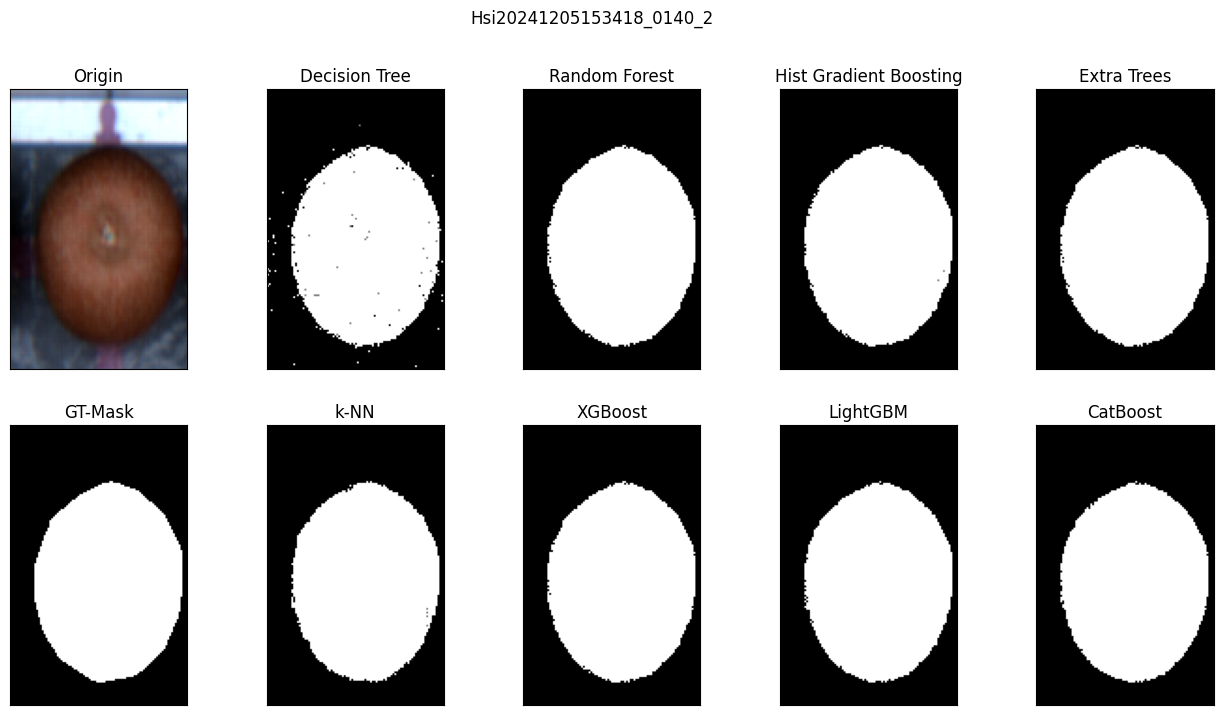

Hsi20241205153418_0140_3


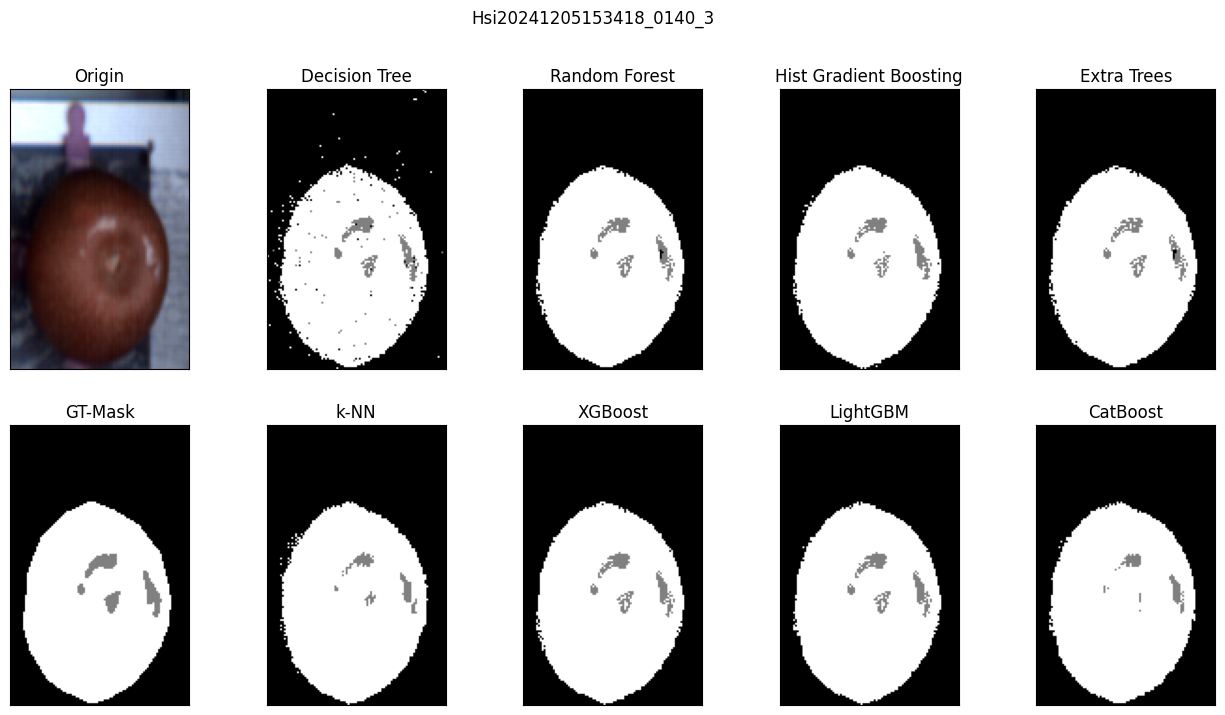

Hsi20241205153418_0140_4


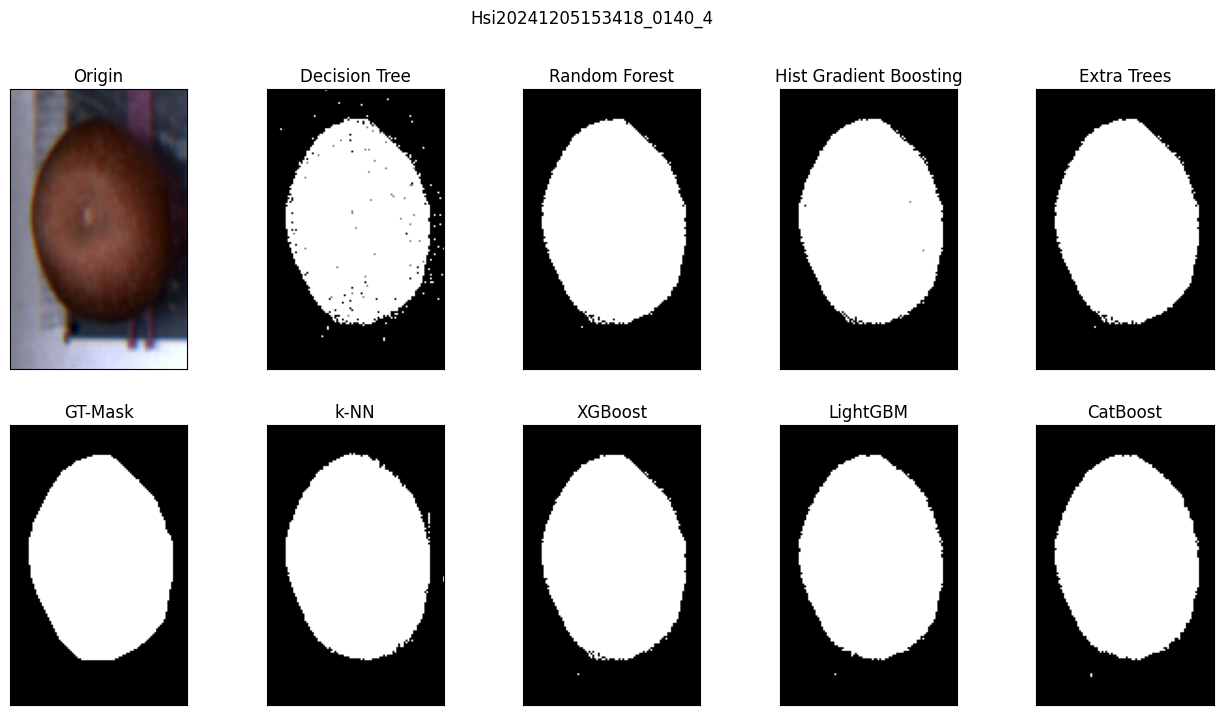

In [63]:
file_list = sorted([f for f in os.listdir(label_folder) if f.endswith('.png')])[:10]

for label_file in file_list:
    base_name = os.path.splitext(label_file)[0]
    hdr_path = os.path.join(hyperspectral_folder, base_name + '.hdr')
    raw_path = hdr_path.replace('.hdr', '.raw')
    label_path = os.path.join(label_folder, label_file)
    
    if not os.path.exists(hdr_path):
        continue
    
    # Load hyperspectral cube
    img = open_image(hdr_path)
    hyperspectral_cube = img.load()
    flattened_cube = hyperspectral_cube.reshape(-1, hyperspectral_cube.shape[-1])  # Shape: (96000, 256)
    preprocessed_cube = apply_differencing(apply_savgol_filter(flattened_cube))
    
    # Load corresponding label image
    label_img = Image.open(label_path).convert('L')

    print(base_name)

    plt.figure(figsize=(16, 8))
    plt.suptitle(base_name)

    plt.subplot(2, 5, 1)
    plt.title("Origin")
    rgb_image = generate_rgb_image(hyperspectral_cube)
    plt.imshow(rgb_image)

    plt.subplot(2, 5, 6)
    plt.title("GT-Mask")
    label_image = label_img.copy()
    plt.imshow(label_image, cmap='gray')

    plt.subplot(2, 5, 2)
    plt.title("Decision Tree")
    model = joblib.load('./weights/Decision Tree_apple_model_compare.pkl')
    pred_image = model.predict(preprocessed_cube).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    plt.subplot(2, 5, 3)
    plt.title("Random Forest")
    model = joblib.load('./weights/Random Forest_apple_model_compare.pkl')
    pred_image = model.predict(preprocessed_cube).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    plt.subplot(2, 5, 4)
    plt.title("Hist Gradient Boosting")
    model = joblib.load('./weights/Hist Gradient Boosting_apple_model_compare.pkl')
    pred_image = model.predict(preprocessed_cube).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    plt.subplot(2, 5, 5)
    plt.title("Extra Trees")
    model = joblib.load('./weights/Extra Trees_apple_model_compare.pkl')
    pred_image = model.predict(preprocessed_cube).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    plt.subplot(2, 5, 7)
    plt.title("k-NN")
    model = joblib.load('./weights/k-NN_apple_model_compare.pkl')
    pred_image = model.predict(preprocessed_cube).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    plt.subplot(2, 5, 8)
    plt.title("XGBoost")
    model = joblib.load('./weights/XGBoost_apple_model_compare.pkl')
    pred_image = model.predict(preprocessed_cube).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    plt.subplot(2, 5, 9)
    plt.title("LightGBM")
    model = joblib.load('./weights/LightGBM_apple_model_compare.pkl')
    pred_image = model.predict(preprocessed_cube).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    plt.subplot(2, 5, 10)
    plt.title("CatBoost")
    model = joblib.load('./weights/CatBoost_apple_model_compare.pkl')
    pred_image = model.predict(preprocessed_cube).reshape(hyperspectral_cube.shape[:2])
    plt.imshow(pred_image, cmap='gray')

    # 모든 subplot의 눈금을 제거
    for ax in plt.gcf().get_axes():
        ax.set_xticks([])
        ax.set_yticks([])

    plt.savefig(f'./OUTPUT/apple/model_test/{base_name}.png')
    plt.show()